# Manual Motion Forecasting

In [1]:
from nuscenes import NuScenes
from nuscenes.prediction import PredictHelper
from nuscenes.eval.prediction.splits import get_prediction_challenge_split
from nuscenes.eval.prediction.data_classes import Prediction
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from nuscenes.prediction.input_representation.static_layers import StaticLayerRasterizer
from nuscenes.prediction.input_representation.agents import AgentBoxesWithFadedHistory
from draw_future_agents import FutureAgentBoxesWithFadedHistory
from nuscenes.prediction.input_representation.interface import InputRepresentation
from nuscenes.prediction.input_representation.combinators import Rasterizer
from nuscenes.map_expansion.map_api import NuScenesMap
from physics import ConstantVelocityHeading, PhysicsOracle

# This is the path where you stored your copy of the nuScenes dataset.
DATAROOT = '/home/patrick/datasets/nuscenes'
nuscenes = NuScenes('v1.0-mini', dataroot=DATAROOT)
mini_train = get_prediction_challenge_split("mini_train", dataroot=DATAROOT)
helper = PredictHelper(nuscenes)
physics_oracle = PhysicsOracle(sec_from_now=6, helper=helper)

nusc_map = NuScenesMap(map_name='singapore-onenorth', dataroot=DATAROOT)
static_layer_rasterizer = StaticLayerRasterizer(helper)

agent_rasterizer = AgentBoxesWithFadedHistory(helper, seconds_of_history=2)
mtp_input_representation = InputRepresentation(static_layer_rasterizer, agent_rasterizer, Rasterizer())

future_agent_rasterizer = FutureAgentBoxesWithFadedHistory(helper, seconds_of_history=5)
future_mtp_input_representation = InputRepresentation(static_layer_rasterizer, future_agent_rasterizer, Rasterizer())

all_instances = get_prediction_challenge_split("mini_train", dataroot=DATAROOT)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.335 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


Selecting index 462 437fe13d66554c51b1ea89f940e5bf4b_f0c059b6d7b8438ea9f08de0a3c1fc1a
(4, 12, 2)


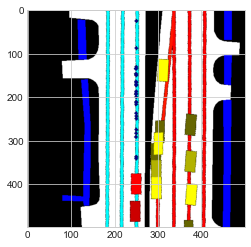

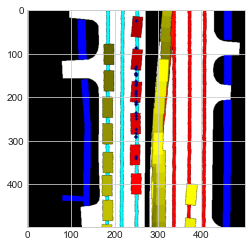

In [22]:
rand_idx = np.random.randint(0, len(all_instances))
instance, sample = mini_train[rand_idx].split("_")
print('Selecting index', rand_idx, mini_train[rand_idx])

predictions = physics_oracle(f"{instance}_{sample}")
print(predictions.prediction.shape)

# draw past
img_past_road = static_layer_rasterizer.make_representation(instance, sample)
img_past_agents = future_agent_rasterizer.make_representation(instance, sample, sec_forward=-2, predictions=predictions)
img_past = Rasterizer().combine([img_past_road, img_past_agents])

plt.figure()
plt.imshow(img_past)

# draw future
img_future_road = static_layer_rasterizer.make_representation(instance, sample)
img_future_agents = future_agent_rasterizer.make_representation(instance, sample, sec_forward=6, predictions=predictions)
img_future = Rasterizer().combine([img_future_road, img_future_agents])

plt.figure()
plt.imshow(img_future)